# Clustering 3K PBMCs with scVI and ScanPy

Disclaimer: some of the code in this notebook was taken from Scanpy's Clustering tutorial (https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html) which is itself based on SEURAT's clustering tutorial in R.

This notebook is designed as a demonstration of scVI's potency on the tasks considered in the Scanpy PBMC 3K Clustering notebook.
In order to do so, we follow the same workflow adopted by scanpy in their clustering tutorial while performing the analysis using scVI as often as possible.
Specifically, we use scVI's latent representation and differential expression analysis (which computes a Bayes Factor on imputed values). 
For visualisation, pre-processing and for some canonical analysis, we use the Scanpy package directly.

When useful, we provide high-level wrappers around scVI's analysis tools. These functions are designed to make standard use of scVI as easy as possible.
For specific use cases, we encourage the reader to take a closer look at those functions and modify them according to his needs.

In [1]:
cd ../../

/Users/angela.pisco/src/sapiens


## Automated testing configuration

In [3]:
%matplotlib inline

In [2]:
# This is for notebook automated testing purpose
def allow_notebook_for_test():
    print("Testing the annotation notebook")

import sys, os

sys.path.append(os.path.abspath("../.."))
n_epochs_all = None
test_mode = False
show_plot = True


def if_not_test_else(x, y):
    if not test_mode:
        return x
    else:
        return y


save_path = "data/"

# End of configuration

## Initialization

In [5]:
# Uncomment to download the data (only works on Unix system)
# !mkdir data
# !wget http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -O data/pbmc3k_filtered_gene_bc_matrices.tar.gz
# !cd data; tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz

In [1]:
# Seed for reproducability
import torch
import numpy as np

torch.manual_seed(0)
np.random.seed(0)

In [3]:
import pandas as pd

import scanpy as sc

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()

scanpy==1.4.4.post1 anndata==0.6.22 umap==0.3.10 numpy==1.17.2 scipy==1.3.1 pandas==0.25.1 scikit-learn==0.21.3 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


In [ ]:
if not test_mode:
    %matplotlib inline
    sc.settings.set_figure_params(dpi=60)

In [ ]:
# Load the data
adata = sc.read_10x_mtx(
    os.path.join(
        save_path, "filtered_gene_bc_matrices/hg19/"
    ),  # the directory with the `.mtx` file
    var_names="gene_symbols",  # use gene symbols for the variable names (variables-axis index)
)
adata.var_names_make_unique()

In [8]:
pwd

'/Users/angela.pisco/src/sapiens'

In [4]:
adata_droplet = sc.read_h5ad('./tabula-sapiens-10X-pilot-raw.h5ad')
display(adata_droplet)
adata_facs = sc.read_h5ad('./data-analysis/pilot/facs/tabula-sapiens-facs-pilot-raw.h5ad')
display(adata_facs)

AnnData object with n_obs × n_vars = 54702 × 26577 
    obs: 'batch', 'replicate', 'tissue', 'method', 'sex', 'subjectid'

AnnData object with n_obs × n_vars = 7278 × 26577 
    obs: 'plate', 'well', 'tissue', 'primary_sort', 'anatomical_position', 'sort_order', 'well_group', 'excluded', 'sort_direction', 'investigator', 'barcode', 'cDNA_prep_person', 'cDNA_dilute', 'library_prep', 'lib_prep_date', 'bead_cleanup', 'BA_nM', 'NovaSeqRun', 'additional_notes'

In [5]:
adata_droplet.obs.drop(columns=['batch'],inplace=True)
adata_droplet.obs.columns

Index(['replicate', 'tissue', 'method', 'sex', 'subjectid'], dtype='object')

In [6]:
adata_facs.obs['method'] = 'facs'

In [7]:
adata = adata_droplet.concatenate(adata_facs)

In [8]:
adata.obs['batch_indices'] = adata.obs['batch']
adata.obs['n_batches'] = adata.obs['batch']

In [9]:
set(adata.obs['method']),set(adata.obs['batch'])

({'droplet', 'facs'}, {'0', '1'})

In [10]:
adata.obs.index = [i[:-2] for i in adata.obs.index]
adata.obs.index
adata

AnnData object with n_obs × n_vars = 61980 × 26577 
    obs: 'BA_nM', 'NovaSeqRun', 'additional_notes', 'anatomical_position', 'barcode', 'batch', 'bead_cleanup', 'cDNA_dilute', 'cDNA_prep_person', 'excluded', 'investigator', 'lib_prep_date', 'library_prep', 'method', 'plate', 'primary_sort', 'replicate', 'sex', 'sort_direction', 'sort_order', 'subjectid', 'tissue', 'well', 'well_group', 'batch_indices', 'n_batches'

In [11]:
adata.obs['tissue'] = adata.obs['tissue'].str.lower()
set(adata.obs['tissue'])

{'bladder',
 'blood',
 'endopancreas',
 'exopancreas1',
 'exopancreas2',
 'lung',
 'muscle',
 'pancreasendocrine',
 'pancreasexocrine'}

In [12]:
adata.obs['tissue'] = adata.obs['tissue'].replace({'endopancreas':'pancreasendocrine'})
adata.obs['tissue'] = adata.obs['tissue'].replace({'exopancreas1':'pancreasexocrine1'})
adata.obs['tissue'] = adata.obs['tissue'].replace({'exopancreas2':'pancreasexocrine2'})
set(adata.obs['tissue'])

{'bladder',
 'blood',
 'lung',
 'muscle',
 'pancreasendocrine',
 'pancreasexocrine',
 'pancreasexocrine1',
 'pancreasexocrine2'}

Bladder


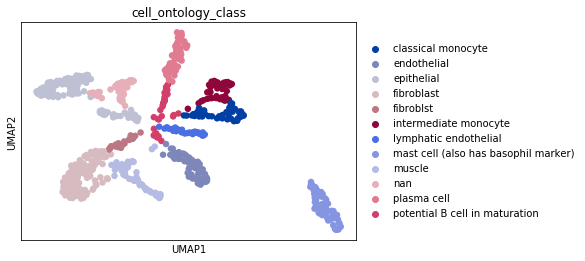

Pancreas_endocrine


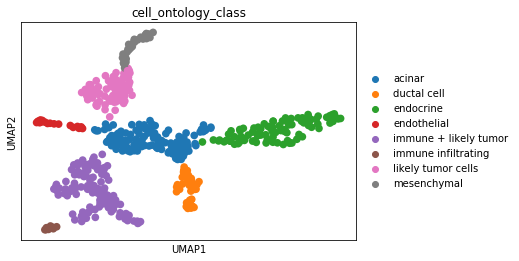

Pancreas_exocrine


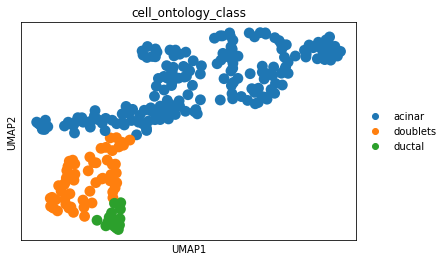

{'acinar',
 'classical monocyte',
 'doublets',
 'ductal',
 'ductal cell',
 'endocrine',
 'endothelial',
 'epithelial',
 'fibroblast',
 'fibroblst',
 'immune + likely tumor',
 'immune infiltrating',
 'intermediate monocyte',
 'likely tumor cells',
 'lymphatic endothelial',
 'mast cell (also has basophil marker)',
 'mesenchymal',
 'muscle',
 'nan',
 'plasma cell',
 'potential B cell in maturation',
 'to-be-annotated'}

In [13]:
adata.obs['provisional_cell_type'] = 'to-be-annotated'
adata.obs['provisional_cell_type'] = adata.obs['provisional_cell_type'].astype(str)

for t in ['Bladder','Pancreas_endocrine','Pancreas_exocrine']:#list(set(adata.obs['tissue'])-set(['Lung','Marrow'])): # 2 tissues missing!
    print(t)
    tiss = sc.read_h5ad('./data-objs/' + t + '_facs_annotation_round_1.h5ad')
    sc.pl.umap(tiss,color=['cell_ontology_class'])
    
    adata.obs.loc[tiss.obs.index,'provisional_cell_type'] = tiss.obs['cell_ontology_class']

set(adata.obs['provisional_cell_type'])

In [14]:
adata.obs.groupby(['method','batch','batch_indices']).count()

BA_nM  NovaSeqRun  additional_notes  \
method  batch batch_indices                                         
droplet 0     0                 0.0         0.0               0.0   
              1                 NaN         NaN               NaN   
        1     0                 NaN         NaN               NaN   
              1                 NaN         NaN               NaN   
facs    0     0                 NaN         NaN               NaN   
              1                 NaN         NaN               NaN   
        1     0                 NaN         NaN               NaN   
              1              7278.0      7278.0            7278.0   

                             anatomical_position  barcode  bead_cleanup  \
method  batch batch_indices                                               
droplet 0     0                              0.0      0.0           0.0   
              1                              NaN      NaN           NaN   
        1     0                              NaN      NaN           NaN   
              1                              NaN      NaN           NaN   
facs    0     0                              NaN      NaN           NaN   
              1                              NaN      NaN           NaN   
        1     0                              NaN      NaN           NaN   
              1                           7278.0   7278.0        7278.0   

                             cDNA_dilute  cDNA_prep_person  excluded  \
method  batch batch_indices                                            
droplet 0     0                      0.0               0.0       0.0   
              1                      NaN               NaN       NaN   
        1     0                      NaN               NaN       NaN   
              1                      NaN               NaN       NaN   
facs    0     0                      NaN               NaN       NaN   
              1                      NaN               NaN       NaN   
        1     0                      NaN               NaN       NaN   
              1                   7278.0            7278.0    7278.0   

                             investigator  ...  replicate      sex  \
method  batch batch_indices                ...                       
droplet 0     0                       0.0  ...    54702.0  54702.0   
              1                       NaN  ...        NaN      NaN   
        1     0                       NaN  ...        NaN      NaN   
              1                       NaN  ...        NaN      NaN   
facs    0     0                       NaN  ...        NaN      NaN   
              1                       NaN  ...        NaN      NaN   
        1     0                       NaN  ...        NaN      NaN   
              1                    7278.0  ...        0.0      0.0   

                             sort_direction  sort_order  subjectid   tissue  \
method  batch batch_indices                                                   
droplet 0     0                         0.0         0.0    54702.0  54702.0   
              1                         NaN         NaN        NaN      NaN   
        1     0                         NaN         NaN        NaN      NaN   
              1                         NaN         NaN        NaN      NaN   
facs    0     0                         NaN         NaN        NaN      NaN   
              1                         NaN         NaN        NaN      NaN   
        1     0                         NaN         NaN        NaN      NaN   
              1                      7278.0      7278.0        0.0   7278.0   

                               well  well_group  n_batches  \
method  batch batch_indices                                  
droplet 0     0                 0.0         0.0    54702.0   
              1                 NaN         NaN        NaN   
        1     0                 NaN         NaN        NaN   
              1                 NaN         NaN        NaN   
fac

## Preprocessing

In the following section, we reproduce the preprocessing steps adopted in the scanpy notebook. 


Basic filtering: we remove cells with a low number of genes expressed and genes which are expressed in a low number of cells.

In [15]:
min_genes = 200#if_not_test_else(200, 0)
min_cells = 3#if_not_test_else(3, 0)

In [16]:
sc.settings.verbosity = 2
sc.pp.filter_cells(adata, min_genes=min_genes)
sc.pp.filter_genes(adata, min_cells=min_cells)
sc.pp.filter_cells(adata, min_genes=1)
sc.pp.filter_cells(adata, min_counts=1000)

adata

filtered out 4097 cells that haveless than 200 genes expressed
filtered out 1757 genes that are detectedin less than 3 cells
filtered out 7297 cells that haveless than 1000 counts


AnnData object with n_obs × n_vars = 50586 × 24820 
    obs: 'BA_nM', 'NovaSeqRun', 'additional_notes', 'anatomical_position', 'barcode', 'batch', 'bead_cleanup', 'cDNA_dilute', 'cDNA_prep_person', 'excluded', 'investigator', 'lib_prep_date', 'library_prep', 'method', 'plate', 'primary_sort', 'replicate', 'sex', 'sort_direction', 'sort_order', 'subjectid', 'tissue', 'well', 'well_group', 'batch_indices', 'n_batches', 'provisional_cell_type', 'n_genes', 'n_counts'
    var: 'n_cells'

As in the scanpy notebook, we then look for high levels of mitochondrial genes and high number of expressed genes which are indicators of poor quality cells.

In [17]:
# mito_genes = adata.var_names.str.startswith("MT-")
# adata.obs["percent_mito"] = (
#     np.sum(adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# )
# adata.obs["n_counts"] = adata.X.sum(axis=1).A1

In [18]:
# adata = adata[adata.obs["n_genes"] < 2500, :]
# adata = adata[adata.obs["percent_mito"] < 0.05, :]

## ⚠ scVI uses non normalized data so we keep the original data in a separate `AnnData` object, then the normalization steps are performed

#####  Normalization and more filtering

We only keep highly variable genes

In [19]:
set(adata.obs['batch_indices'])

{'0', '1'}

In [20]:
set(adata.obs[adata.obs['method']=='droplet']['batch_indices'])

{'0'}

In [21]:
adata_original = adata.copy()

sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)


min_mean = .0125#if_not_test_else(0.0125, -np.inf)
max_mean = 3#if_not_test_else(3, np.inf)
min_disp = .5#if_not_test_else(0.5, -np.inf)
max_disp = None#if_not_test_else(None, np.inf)

sc.pp.highly_variable_genes(
    adata,
    min_mean=min_mean,
    max_mean=max_mean,
    min_disp=min_disp,
    max_disp=max_disp
    # n_top_genes=500
)

adata.raw = adata

highly_variable_genes = adata.var["highly_variable"]
# adata = adata[:, highly_variable_genes]

# sc.pp.regress_out(adata, ["n_counts", "percent_mito"])
sc.pp.scale(adata, max_value=10)

# Also filter the original adata genes
# adata_original = adata_original[:, highly_variable_genes]
print(highly_variable_genes.sum())

# We also store adata_original into adata.raw
# (which was designed for this purpose but actually has limited functionnalities)
adata.raw = adata_original

normalizing by total count per cell
    finished (0:00:02): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:08)
2899


In [ ]:
sc.pp.combat(adata)
adata

Standardizing Data across genes.

Found 2 batches

Found 0 numerical variables:
	



In [22]:
adata, adata_original

(AnnData object with n_obs × n_vars = 50586 × 24820 
     obs: 'BA_nM', 'NovaSeqRun', 'additional_notes', 'anatomical_position', 'barcode', 'batch', 'bead_cleanup', 'cDNA_dilute', 'cDNA_prep_person', 'excluded', 'investigator', 'lib_prep_date', 'library_prep', 'method', 'plate', 'primary_sort', 'replicate', 'sex', 'sort_direction', 'sort_order', 'subjectid', 'tissue', 'well', 'well_group', 'batch_indices', 'n_batches', 'provisional_cell_type', 'n_genes', 'n_counts'
     var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm',
 AnnData object with n_obs × n_vars = 50586 × 24820 
     obs: 'BA_nM', 'NovaSeqRun', 'additional_notes', 'anatomical_position', 'barcode', 'batch', 'bead_cleanup', 'cDNA_dilute', 'cDNA_prep_person', 'excluded', 'investigator', 'lib_prep_date', 'library_prep', 'method', 'plate', 'primary_sort', 'replicate', 'sex', 'sort_direction', 'sort_order', 'subjectid', 'tissue', 'well', 'well_group', 'batch_indices', 'n_batches', 'provisional_cell_type'

In [23]:
adata.write('./sapiens-facs-droplet-processed.h5ad')

... storing 'BA_nM' as categorical
... storing 'NovaSeqRun' as categorical
... storing 'additional_notes' as categorical
... storing 'anatomical_position' as categorical
... storing 'barcode' as categorical
... storing 'bead_cleanup' as categorical
... storing 'cDNA_dilute' as categorical
... storing 'cDNA_prep_person' as categorical
... storing 'excluded' as categorical
... storing 'investigator' as categorical
... storing 'lib_prep_date' as categorical
... storing 'library_prep' as categorical
... storing 'method' as categorical
... storing 'plate' as categorical
... storing 'primary_sort' as categorical
... storing 'replicate' as categorical
... storing 'sex' as categorical
... storing 'sort_direction' as categorical
... storing 'sort_order' as categorical
... storing 'subjectid' as categorical
... storing 'tissue' as categorical
... storing 'well' as categorical
... storing 'well_group' as categorical
... storing 'provisional_cell_type' as categorical


## Compute the scVI latent space

Below we provide then use a wrapper function designed to compute scVI's latent representation of the non-normalized data. Specifically, we train scVI's VAE, compute and store the latent representation then return the posterior which will later be used for further inference.

In [115]:
import scvi
from scvi.dataset import AnnDatasetFromAnnData
from scvi.inference import UnsupervisedTrainer
from scvi.models.vae import VAE
from typing import Tuple


def compute_scvi_latent(
    adata: sc.AnnData,
    n_latent: int = 6,
    n_epochs: int = 100,
    lr: float = 1e-3,
    use_batches: bool = False,
    use_cuda: bool = False,
) -> Tuple[scvi.inference.Posterior, np.ndarray]:
    """Train and return a scVI model and sample a latent space
    
    :param adata: sc.AnnData object non-normalized
    :param n_latent: dimension of the latent space
    :param n_epochs: number of training epochs
    :param lr: learning rate
    :param use_batches
    :param use_cuda
    :return: (scvi.Posterior, latent_space)
    """
    # Convert easily to scvi dataset
    scviDataset = AnnDatasetFromAnnData(adata)

    # Train a model
    vae = VAE(
        scviDataset.nb_genes,
        n_batch=scviDataset.n_batches * use_batches,
        n_hidden=128, n_latent=30, n_layers=5, dispersion='gene'
    )
    trainer = UnsupervisedTrainer(vae, scviDataset, train_size=.99, use_cuda=use_cuda)
    trainer.train(n_epochs=n_epochs, lr=lr)
    ####

    # Extract latent space
    posterior = trainer.create_posterior(
        trainer.model, scviDataset, indices=np.arange(len(scviDataset))
    ).sequential()

    latent, _, _ = posterior.get_latent()

    return posterior, latent

In [116]:
n_epochs = 100 if n_epochs_all is None else n_epochs_all

scvi_posterior, scvi_latent = compute_scvi_latent(
    adata_original, n_epochs=n_epochs, n_latent=6,
    use_batches = True
)
adata.obsm["X_scvi"] = scvi_latent

[2019-09-15 11:09:37,440] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2019-09-15 11:09:37,487] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2019-09-15 11:09:39,123] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2019-09-15 11:09:42,595] INFO - scvi.dataset.dataset | Downsampled from 50586 to 50586 cells


training: 100%|██████████| 100/100 [10:51:38<00:00, 390.99s/it] 


In [117]:
adata.write('./sapiens-scVI-facs-droplet-all-genes.h5ad')

... storing 'BA_nM' as categorical
... storing 'NovaSeqRun' as categorical
... storing 'additional_notes' as categorical
... storing 'anatomical_position' as categorical
... storing 'barcode' as categorical
... storing 'bead_cleanup' as categorical
... storing 'cDNA_dilute' as categorical
... storing 'cDNA_prep_person' as categorical
... storing 'excluded' as categorical
... storing 'investigator' as categorical
... storing 'lib_prep_date' as categorical
... storing 'library_prep' as categorical
... storing 'method' as categorical
... storing 'plate' as categorical
... storing 'primary_sort' as categorical
... storing 'replicate' as categorical
... storing 'sex' as categorical
... storing 'sort_direction' as categorical
... storing 'sort_order' as categorical
... storing 'subjectid' as categorical
... storing 'tissue' as categorical
... storing 'well' as categorical
... storing 'well_group' as categorical
... storing 'provisional_cell_type' as categorical


## Principal component analysis to reproduce ScanPy results and compare them against scVI's

Below, we reproduce exactly scanpy's PCA on normalized data.

In [6]:
adata = sc.read_h5ad('sapiens-scVI-facs-droplet-all-genes.h5ad')
adata

AnnDataReadError: Above error raised while reading key '/obs/BA_nM' of type <class 'h5py._hl.dataset.Dataset'> from /.

In [118]:
sc.tl.pca(adata, svd_solver="arpack")

computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:02:00)


In [119]:
adata

AnnData object with n_obs × n_vars = 50586 × 24820 
    obs: 'BA_nM', 'NovaSeqRun', 'additional_notes', 'anatomical_position', 'barcode', 'batch', 'bead_cleanup', 'cDNA_dilute', 'cDNA_prep_person', 'excluded', 'investigator', 'lib_prep_date', 'library_prep', 'method', 'plate', 'primary_sort', 'replicate', 'sex', 'sort_direction', 'sort_order', 'subjectid', 'tissue', 'well', 'well_group', 'batch_indices', 'n_batches', 'provisional_cell_type', 'n_genes', 'n_counts'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca'
    obsm: 'X_scvi', 'X_pca'
    varm: 'PCs'

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


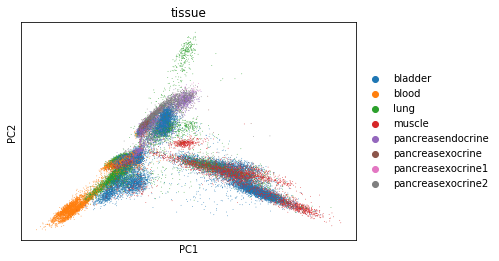

In [120]:
sc.pl.pca(adata, color='tissue')#, show=show_plot)

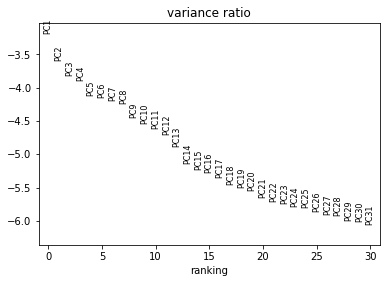

In [121]:
sc.pl.pca_variance_ratio(adata, log=True)#, show=show_plot)

## Computing, embedding and clustering the neighborhood graph

The Scanpy API computes a neighborhood graph with `sc.pp.neighbors` which can be called to work on a specific representation `use_rep='your rep'`.
Once the neighbors graph has been computed, all Scanpy algorithms working on it can be called as usual (that is *louvain*, *paga*, *umap* ...)

### Using PCA representation (Scanpy tutorial)

In [122]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.louvain(adata, key_added="louvain_pca")
sc.tl.umap(adata)

computing neighbors
    using 'X_pca' with n_pcs = 40


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  self.func_ir.loc))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#

    finished (0:00:24)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:12)
computing UMAP
    finished (0:00:42)


In [ ]:
sc.pl.umap(adata, color=["louvain_pca", "tissue", 'method','batch',"EPCAM", "CD36"], ncols=3, cmap='Oranges', save='_sapiens_combined2.pdf')

### Using scVI latent space representation

In [123]:
sc.pp.neighbors(adata, n_neighbors=20, n_pcs=40, use_rep="X_scvi")
sc.tl.umap(adata)

computing neighbors


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  self.func_ir.loc))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html

    finished (0:00:11)
computing UMAP
    finished (0:00:46)


In [124]:
sc.tl.louvain(adata, key_added="louvain_scvi", resolution=0.7)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:12)


In [ ]:
sc.pl.umap(adata, color=["louvain_scvi", "tissue",'method','batch','EPCAM','CD36'], ncols=3, save='_sapiens_combined_scvi2.pdf')

In [ ]:
sc.pl.umap(adata[adata.obs['tissue'].isin(['Bladder','bladder'])], color=["louvain_scvi", "tissue",'method'], ncols=3)
sc.pl.umap(adata[adata.obs['tissue'].isin(['Muscle','muscle'])], color=["louvain_scvi", "tissue",'method'], ncols=3)


In [ ]:
adata

In [125]:
adata.write('./sapiens-scVI-facs-droplet-processed-all-genes.h5ad')

In [4]:
pwd

'/Users/angela.pisco/src/sapiens/tabula-sapiens/analysis-scripts'

In [5]:
adata = sc.read_h5ad('../../sapiens-scVI-facs-droplet-processed.h5ad')
adata

AnnData object with n_obs × n_vars = 57883 × 2485 
    obs: 'BA_nM', 'NovaSeqRun', 'additional_notes', 'anatomical_position', 'barcode', 'batch', 'bead_cleanup', 'cDNA_dilute', 'cDNA_prep_person', 'excluded', 'investigator', 'lib_prep_date', 'library_prep', 'method', 'plate', 'primary_sort', 'replicate', 'sex', 'sort_direction', 'sort_order', 'subjectid', 'tissue', 'well', 'well_group', 'batch_indices', 'n_batches', 'n_genes', 'n_counts', 'louvain_pca', 'louvain_scvi'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'batch_colors', 'louvain', 'louvain_pca_colors', 'louvain_scvi_colors', 'method_colors', 'neighbors', 'pca', 'tissue_colors'
    obsm: 'X_pca', 'X_scvi', 'X_umap'
    varm: 'PCs'

# Get initial stats + annotations

In [ ]:
adata = sc.read_h5ad('./sapiens-scVI-facs-droplet-processed.h5ad')

In [ ]:
adata

In [ ]:
set(adata.obs['tissue'])

In [ ]:
adata.obs['tissue'] = adata.obs['tissue'].str.lower()
set(adata.obs['tissue'])

In [ ]:
adata.obs['tissue'] = adata.obs['tissue'].replace({'endopancreas':'pancreasendocrine'})
adata.obs['tissue'] = adata.obs['tissue'].replace({'exopancreas1':'pancreasexocrine1'})
adata.obs['tissue'] = adata.obs['tissue'].replace({'exopancreas2':'pancreasexocrine2'})
set(adata.obs['tissue'])

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
df = adata.obs.groupby(['tissue','method'])['tissue'].agg({'nb cells':len})
df = df.reset_index()
df['nb cells'] = df['nb cells'].fillna(0)
# df

figure, axes = plt.subplots(1, 2, figsize=(20, 7))
sns.barplot(x = 'nb cells', y= 'tissue', data=df[df['method']=='facs'], ax = axes[0])
sns.barplot(x = 'nb cells', y= 'tissue', data=df[df['method']=='droplet'], ax = axes[1])

# g.set_xscale("log")
# g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)


plt.tight_layout()

In [ ]:
adata.obs.columns

In [ ]:
pwd

In [ ]:
tiss = sc.read_h5ad('./data-objs/Bladder_facs_annotation_round_1.h5ad')
display(tiss)
tiss.obs.columns

In [ ]:
set(adata.obs['tissue'])

In [ ]:
tiss.obs.index

In [ ]:
adata.obs.index = [i[:-2] for i in adata.obs.index]
adata.obs.index

In [ ]:
adata.obs['provisional_cell_type'] = 'to-be-annotated'
adata.obs['provisional_cell_type'] = adata.obs['provisional_cell_type'].astype(str)

for t in ['Bladder','Pancreas_endocrine','Pancreas_exocrine']:#list(set(adata.obs['tissue'])-set(['Lung','Marrow'])): # 2 tissues missing!
    print(t)
    tiss = sc.read_h5ad('./data-objs/' + t + '_facs_annotation_round_1.h5ad')
    sc.pl.umap(tiss,color=['cell_ontology_class'])
    
    adata.obs.loc[tiss.obs.index,'provisional_cell_type'] = tiss.obs['cell_ontology_class']

#adata.obs = adata.obs.replace({'18m-not-annotated':'nan'})

In [ ]:
sc.pl.umap(adata,color='provisional_cell_type')

In [ ]:
adata.obs.columns


In [ ]:
adata.obs.groupby(['tissue','method','provisional_cell_type']).agg({'provisional_cell_type':'size'})

In [ ]:
sc.pl.umap(adata[adata.obs['tissue'].isin(['bladder'])], color=["louvain_scvi", 'method','provisional_cell_type'], ncols=3)
sc.pl.umap(adata[adata.obs['tissue'].isin(['pancreasendocrine'])], color=["louvain_scvi",'provisional_cell_type'], ncols=3)


In [ ]:
tiss

In [ ]:
tiss

In [ ]:
tiss = adata[adata.obs['tissue']==t]

In [ ]:
np.max(tiss.X)

In [ ]:
for t in ['bladder']:#,'Pancreas_endocrine','Pancreas_exocrine']:#list(set(adata.obs['tissue'])-set(['Lung','Marrow'])): # 2 tissues missing!
    print(t)
    print('comparing to annotated data')
    methodofinterest = ['facs']
    
    tiss = adata[adata.obs['tissue']==t]
    sc.pp.normalize_per_cell(tiss, counts_per_cell_after=1e4) #simple lib size normalization?
#     sc.pp.highly_variable_genes(tiss, subset = False, min_disp=.5, max_disp=None, min_mean=.0125, max_mean=10, n_bins=20, n_top_genes=None)
#     sc.pp.log1p(tiss)
#     sc.pp.scale(tiss, max_value=10, zero_center=False)
#     sc.tl.pca(tiss)
#     sc.pl.pca_overview(tiss)
    sc.pp.neighbors(tiss, n_neighbors=12, n_pcs=30)
    sc.tl.louvain(tiss, resolution = .7)
    sc.tl.leiden(tiss, resolution = 1)
    
    tissaux = tiss[tiss.obs['method'].isin(methodofinterest)]
    
#     print(tissaux)
    tiss_cell_ontology_class = {}
    for i in set(tissaux.obs['leiden']):
        df = tissaux.obs[tissaux.obs['leiden']==i]['provisional_cell_type']
        df.reset_index()
        df = df.reset_index()
        dfaux = df.groupby('provisional_cell_type').count()/df.groupby('provisional_cell_type').count().sum()
        dfaux.reset_index()
        dfaux = dfaux.reset_index()
        a = dfaux[dfaux['index']>0.95][['provisional_cell_type']]
        if a.empty:
            tiss_cell_ontology_class[i] = 'tbc'
        else:
            tiss_cell_ontology_class[i] = a.values[0][0]

    tiss_cell_ontology_class
    print(set(tiss_cell_ontology_class.values()))
    print(set(tissaux.obs['provisional_cell_type']))

    print('mapping new annotations')
    tiss.obs['auto_provisional_cell_type'] = tiss.obs['leiden'].map(tiss_cell_ontology_class)
    set(tiss.obs['auto_provisional_cell_type'])
    print('saving graphical outputs')
    sc.pl.umap(tiss, color=['leiden','provisional_cell_type','auto_provisional_cell_type'],ncols=2)

In [ ]:
set(adata.obs['provisional_cell_type'])

In [ ]:
adata.write('./sapiens-scVI-facs-droplet-processed-annotated-round1.h5ad')

## Finding marker genes

ScanPy tries to determine marker genes using a *t-test* and a *Wilcoxon* test.

For the same task, from scVI's trained VAE model we can sample the gene expression rate for each gene in each cell. For the two populations of interest, we can then randomly sample pairs of cells, one from each population to compare their expression rate for a gene. The degree of **differential expression** is measured by logit($\frac{p}{1-p}$) (Bayes Factor) where $p$ is the probability of a cell from population $A$ having a higher expression than a cell from population $B$. We can form the null distribution of the DE values by sampling pairs randomly from the combined population.

Below, we provide a wrapper around scVI's differential expression process. Specifically, it computes the average of the Bayes factor where population $A$ covers each cluster in `adata.obs[label_name]` and is compared with the aggregate formed by all the other clusters.

In [ ]:
def rank_genes_groups_bayes(
    adata: sc.AnnData,
    scvi_posterior: scvi.inference.Posterior,
    n_samples: int = None,
    M_permutation: int = None,
    n_genes: int = 25,
    label_name: str = "louvain_scvi",
) -> pd.DataFrame:
    """
    Rank genes for characterizing groups. 
    Computes Bayes factor for each cluster against the others to test for differential expression.
    See Nature article (https://rdcu.be/bdHYQ)

    :param adata: sc.AnnData object non-normalized
    :param scvi_posterior: 
    :param n_samples: 
    :param M_permutation: 
    :param n_genes: 
    :param label_name: The groups tested are taken from adata.obs[label_name] which can be computed 
                       using clustering like Louvain (Ex: sc.tl.louvain(adata, key_added=label_name) )
    :return: Summary of Bayes factor per gene, per cluster
    """

    # Call scvi function
    per_cluster_de, cluster_id = scvi_posterior.one_vs_all_degenes(
        cell_labels=np.asarray(adata.obs[label_name].values).astype(int).ravel(),
        min_cells=1,
        n_samples=n_samples,
        M_permutation=M_permutation,
    )

    # convert to ScanPy format -- this is just about feeding scvi results into a format readable by ScanPy
    markers = []
    scores = []
    names = []
    for i, x in enumerate(per_cluster_de):
        subset_de = x[:n_genes]
        markers.append(subset_de)
        scores.append(tuple(subset_de["bayes1"].values))
        names.append(tuple(subset_de.index.values))

    markers = pd.concat(markers)
    dtypes_scores = [(str(i), "<f4") for i in range(len(scores))]
    dtypes_names = [(str(i), "<U50") for i in range(len(names))]
    scores = np.array([tuple(row) for row in np.array(scores).T], dtype=dtypes_scores)
    scores = scores.view(np.recarray)
    names = np.array([tuple(row) for row in np.array(names).T], dtype=dtypes_names)
    names = names.view(np.recarray)

    adata.uns["rank_genes_groups_scvi"] = {
        "params": {
            "groupby": "",
            "reference": "rest",
            "method": "",
            "use_raw": True,
            "corr_method": "",
        },
        "scores": scores,
        "names": names,
    }
    return markers

### Use a t-test on scvi_clusters like in the ScanPy tutorial

In [ ]:
n_genes = 20
sc.tl.rank_genes_groups(
    adata,
    "louvain_scvi",
    method="t-test",
    use_raw=False,
    key_added="rank_genes_groups_ttest",
    n_genes=n_genes,
)
sc.tl.rank_genes_groups(
    adata,
    "louvain_scvi",
    method="wilcoxon",
    use_raw=False,
    key_added="rank_genes_groups_wilcox",
    n_genes=n_genes,
)
sc.pl.rank_genes_groups(
    adata, key="rank_genes_groups_ttest", sharey=False, n_genes=n_genes, show=show_plot
)
sc.pl.rank_genes_groups(
    adata, key="rank_genes_groups_wilcox", sharey=False, n_genes=n_genes, show=show_plot
)

### Use differential expression from the scVI posterior

In [ ]:
rank_genes_groups_bayes(
    adata, scvi_posterior, label_name="louvain_scvi", n_genes=n_genes
)
sc.pl.rank_genes_groups(
    adata, key="rank_genes_groups_scvi", sharey=False, n_genes=n_genes, show=show_plot
)

### Measure similarity between *scVI differential expression*, *t-test* and *wilcoxon-test*

In [ ]:
# We compute the rank of every gene to perform analysis after
all_genes = len(adata.var_names)

sc.tl.rank_genes_groups(adata, 'louvain_scvi', method='t-test',   use_raw=False, key_added='rank_genes_groups_ttest',  n_genes=all_genes)
sc.tl.rank_genes_groups(adata, 'louvain_scvi', method='wilcoxon', use_raw=False, key_added='rank_genes_groups_wilcox', n_genes=all_genes)
differential_expression = rank_genes_groups_bayes(adata, scvi_posterior, label_name='louvain_scvi', n_genes=all_genes)

In [ ]:
def ratio(A, B):
    A, B = set(A), set(B)
    return len(A.intersection(B)) / len(A) * 100

In [ ]:
cluster_distrib = adata.obs.groupby("louvain_scvi").count()["n_genes"]

For each cluster, we compute the percentage of genes which are in the `n_genes` most expressed  genes of both Scanpy's and scVI's differential expression tests.

In [ ]:
n_genes = 25

sc.pl.umap(adata, color=["louvain_scvi"], ncols=1, show=show_plot)
for c in cluster_distrib.index:
    print(
        "Cluster %s (%d cells): t-test / wilcox %6.2f %%  & t-test / scvi %6.2f %%"
        % (
            c,
            cluster_distrib[c],
            ratio(
                adata.uns["rank_genes_groups_ttest"]["names"][c][:n_genes],
                adata.uns["rank_genes_groups_wilcox"]["names"][c][:n_genes],
            ),
            ratio(
                adata.uns["rank_genes_groups_ttest"]["names"][c][:n_genes],
                adata.uns["rank_genes_groups_scvi"]["names"][c][:n_genes],
            ),
        )
    )

## Plot px_scale for most expressed genes and less expressed genes by cluster

Sample the scale for all the data (all genes, cells), average on multiple samples

``` python
scale = scvi_posterior.get_sample_scale()
for _ in range(9):
    scale += scvi_posterior.get_sample_scale()
scale /= 10

for gene, gene_scale in zip(adata.var.index, np.squeeze(scale).T):
    adata.obs["scale_" + gene] = gene_scale
    
```

This is not tractable for large dataset so we provide another function below

In [ ]:
from typing import List


def get_scales_per_gene(
    gene_names: List[str],
    adata: sc.AnnData,
    scvi_posterior: scvi.inference.Posterior,
    n_samples: int = 10,
    batchsize: int = 32,
):
    """Get imputed values for each gene in gene_names - for each cell in adata. Performed inplace.
    Scales are added in adata.obs under the alias 'scale_' + gene_name.
    
    This function handles very large dataset thanks to batch size control

    Args:
        gene_names: list of gene names
        adata: scRNAseq dataset
        posterior: scVI Posterior object
        n_samples: number of samples to average on
        batchsize: for computation: number of cells to query in each iteration
    """
    all_gene_names = list(scvi_posterior.gene_dataset.gene_names)
    gene_idx = [all_gene_names.index(g) for g in gene_names]
    ashape = scvi_posterior.gene_dataset.X.shape
    px_scales = np.zeros((len(gene_names), n_samples, ashape[0]))
    for idx in range(int(ashape[0] / batchsize)):
        current_slice = slice(idx * batchsize, (idx + 1) * batchsize)
        px_scales_batch = scvi_posterior.model.get_sample_scale(
            torch.from_numpy(scvi_posterior.gene_dataset.X[current_slice]),
            n_samples=n_samples,
        )
        px_scales[:, :, current_slice] = np.transpose(
            px_scales_batch.detach().numpy()[:, :, gene_idx], (2, 0, 1)
        )
    for name, scales in zip(gene_names, px_scales):
        adata.obs["scale_" + name] = scales.mean(axis=0)

#### Most differentialy expressed genes

In [ ]:
cluster_id = 2
n_best_genes = 10
gene_names = differential_expression[
    differential_expression["clusters"] == cluster_id
].index.tolist()[:n_best_genes]
gene_names

In [ ]:
get_scales_per_gene(gene_names, adata, scvi_posterior)

In [ ]:
print("Top genes for cluster %d" % cluster_id)
sc.pl.umap(adata, color=["louvain_scvi"] + ["scale_" + g for g in gene_names], ncols=3, show=show_plot)

#### Less differentialy expressed genes

In [ ]:
cluster_id = 2
n_best_genes = 10
gene_names = differential_expression[
    differential_expression["clusters"] == cluster_id
].index.tolist()[-n_best_genes:]
gene_names

In [ ]:
get_scales_per_gene(gene_names, adata, scvi_posterior)

In [ ]:
print("Top down regulated genes for cluster %d" % cluster_id)
sc.pl.umap(adata, color=["louvain_scvi"] + ["scale_" + g for g in gene_names], ncols=3, show=show_plot)

### Analyze ranking difference between **t-test** and **scVI**

In [ ]:
cluster_id = if_not_test_else("2", "0")

In [ ]:
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt


def plot_ranking(method_1, method_2):
    mapping = defaultdict(list)

    for rank, gene in enumerate(
        adata.uns["rank_genes_groups_" + method_1]["names"][cluster_id]
    ):
        mapping[gene].append(rank)
    for rank, gene in enumerate(
        adata.uns["rank_genes_groups_" + method_2]["names"][cluster_id]
    ):
        mapping[gene].append(rank)

    x, y = np.array(list(mapping.values())).T

    # n_genes = all_genes
    n_genes = all_genes

    plt.figure(figsize=(8, 8))
    sns.scatterplot(x, y, s=10)
    plt.axhline(100, c="red")
    plt.axvline(100, c="red")
    plt.xlim(0, n_genes)
    plt.ylim(0, n_genes)
    plt.xlabel(method_1 + " ranking")
    plt.ylabel(method_2 + " ranking")

In [ ]:
plot_ranking("scvi", "ttest")
plot_ranking("wilcox", "ttest")

### Investigating discrepancies

Cluster 4 top genes of t-test and scvi are totally different, but when we look closer at the data one can notice:
- The Bayes factor (or t-test score) are all very low for the cluster (no genes are significant)
- Plots confirm the latter point: the top genes are not specific to the cluster and are either noise or overlapping with other clusters

Specifically, we plot first the expression levels of genes selected by scVI, then of genes selected by the t-test. In both cases, genes seem irrelevant.

In [ ]:
n_genes = 10

cluster_id = if_not_test_else(2, 0)

genes = differential_expression[
    differential_expression["clusters"] == cluster_id
].index.tolist()
sc.pl.umap(
    adata,
    color=["louvain_scvi"]
    + adata.uns["rank_genes_groups_scvi"]["names"][str(cluster_id)].tolist()[:n_genes],
    ncols=3,
    show=show_plot,
)
sc.pl.umap(
    adata,
    color=["louvain_scvi"]
    + adata.uns["rank_genes_groups_ttest"]["names"][str(cluster_id)].tolist()[:n_genes],
    ncols=3,
    show=show_plot,
)

scVi tends to predict samples that are not expressed outside the cluster when t-test tends to select highly expressed genes in the cluster even if it also expressed everywhere.

### Store differential expression scores

In [ ]:
def store_de_scores(
    adata: sc.AnnData, differential_expression: pd.DataFrame, save_path: str = None
):
    """Creates, returns and writes a DataFrame with all the differential scores used in this notebook.
    
    Args:
        adata: scRNAseq dataset
        differential_expression: Pandas Dataframe containing the bayes factor for all genes and clusters
        save_path: file path for writing the resulting table

    Returns:
        pandas.DataFrame containing the scores of each differential expression test.

    """
    # get shapes for array initialisation
    n_genes_de = differential_expression[
        differential_expression["clusters"] == 0
    ].shape[0]
    all_genes = adata.shape[1]
    # check that all genes have been used
    if n_genes_de != all_genes:
        raise ValueError(
            "scvi differential expression has to have been run with n_genes=all_genes"
        )
    # get tests results from AnnData unstructured annotations
    rec_scores = []
    rec_names = []
    test_types = ["ttest", "wilcox"]
    for test_type in test_types:
        res = adata.uns["rank_genes_groups_" + test_type]
        rec_scores.append(res["scores"])
        rec_names.append(res["names"])
    # restrict scvi table to bayes factor
    res = differential_expression[["bayes1", "clusters"]]
    # for each cluster join then append all
    dfs_cluster = []
    groups = res.groupby("clusters")
    for cluster, df in groups:
        for rec_score, rec_name, test_type in zip(rec_scores, rec_names, test_types):
            temp = pd.DataFrame(
                rec_score[str(cluster)],
                index=rec_name[str(cluster)],
                columns=[test_type],
            )
            df = df.join(temp)
        dfs_cluster.append(df)
    res = pd.concat(dfs_cluster)
    if save_path:
        res.to_csv(save_path)
    return res

In [ ]:
de_table = store_de_scores(adata, differential_expression, save_path=None)
de_table.head()

# Running other ScanPy algorithms is easy, binding the index keys

### PAGA

In [ ]:
sc.tl.paga(adata, groups="louvain_scvi")
sc.pl.paga(adata, show=show_plot)

###  HeatMap

In [ ]:
marker_genes = [
    "CD79A",
    "MS4A1",
    "LGALS3",
    "S100A8",
    "GNLY",
    "NKG7",
    "KLRB1",
    "FCGR3A",
    "FCER1A",
    "CST3",
    "PPBP",
]

In [ ]:
sc.pl.heatmap(adata, marker_genes, groupby="louvain_scvi", dendrogram=True, show=show_plot)